# Detection of fake accounts on Twitter.
## Motivation

In today's society, Social Networks are a primary source of information. Users utilize websites such as Twitter and Facebook to inform them selves about the latest events, discuss politics or social issues. It has also become a news outlet for traditional newspapers such as the New York Times or the Wall Street Journal. Politicians use Social Networks to communicate with the public. 

Independent parties use bots or large networks of bots which operate on these networks to fullfil their goals. Not all bots are malicious, such as bots which provide weather forecasts[1]. 

Three types of bot threads can be identified [1]. These bots often impersonate a real identity and therefore are difficult to distinguish from real users:
- Fraud: These types of bots deceive social media users to obtain money or private information.
- Promotion of harmful or censored information: Bots are utilized to spread propaganda or misinformation. These include:
    1. Thread to integrity: exacerbate conflict or violate the integrity of a community.
    2. Thread to availability: Drown alternative viewpoints with spam messages.

- Rating manipulation: Certain content is elevated through fake feedback including reviews, likes or followers.


With the increasing effectiveness as well as ease of access of generative AI, such as text and image generation models more sophisticated impersonations and generation of fake media can be achieved, difficult or impossible to distinguish from real content. Malicious-bot operators have gained access to multi-billion dollar means which camouflage their bots' behavior. The generative models, trained with human feedback to be indistinguishable from real content, diminish the out-of-distribution shift which was previously easily detectable. 

Thus the focus of this notebook shifts towards the behavioral and interaction patterns in social networks as well as user metadata to distinguish real from fake users.


[1] https://www.researchgate.net/profile/Maxim-Kolomeets/publication/358490063_Algorithms_and_techniques_for_bot_detection_in_social_networks/links/62afd5c5938bee3e3f438138/Algorithms-and-techniques-for-bot-detection-in-social-networks.pdf

## Dataset
Courtesy of Shangbin Feng this notebook uses the TwiBot-22 dataset[2] to analyze a social network graph of Twitter.
The authors try to ensure a distribution diversity (follower counts, user types) as well as value diversity (less similar neighbors are included) in the dataset. 

Human experts classify 1000 random users. Different classifiers are trained to distinguish the bots from the real users and their results are incorporated using the data augmentation technique Snorkel[3] to annotate the remaining users collected.

The dataset contains one million users as well as 88 million tweets. In total, the graph contains 92.9 million entities and 170 million relations amounting to a 6 GB file.



The graph comprises following node and edge types [2]:
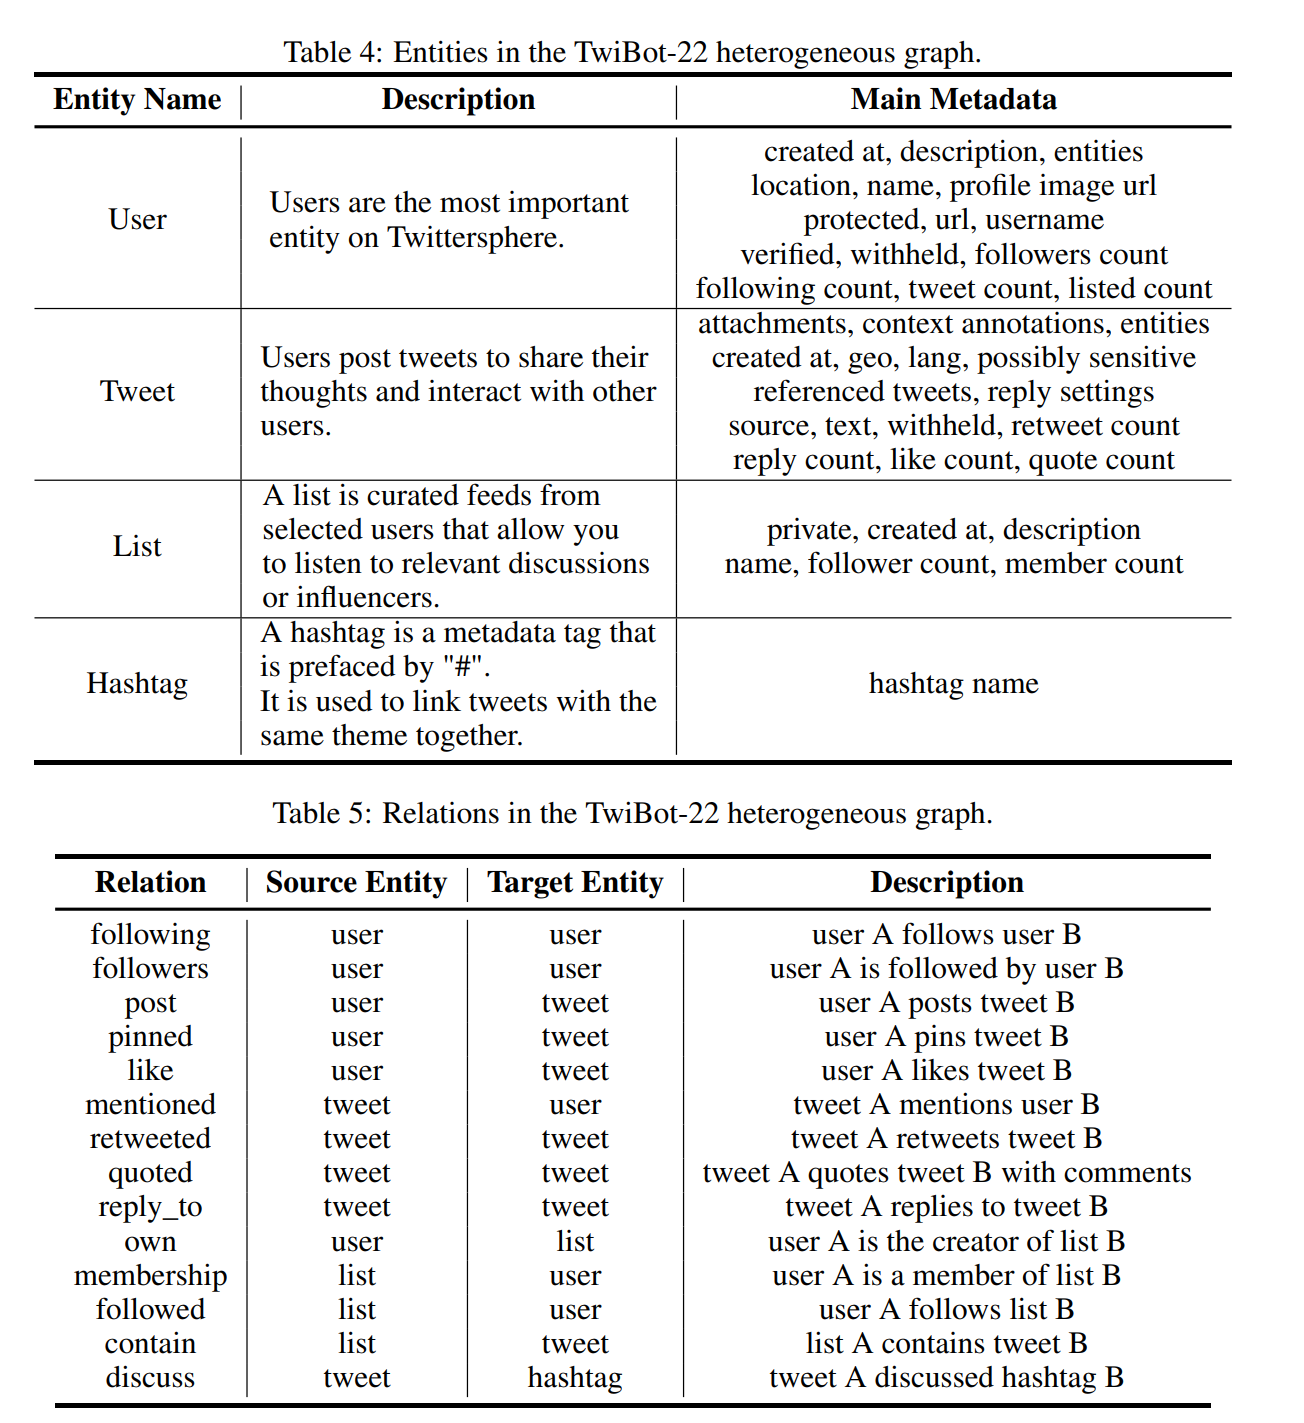

Besides the network information, TwiBot-22 also contains over 100 GB tweet information, which is not used in this notebook.

[2] https://arxiv.org/abs/2206.04564
[3] https://dawn.cs.stanford.edu/pubs/ratner-vldb2018.pdf

In [1]:
import pandas as pd 
import numpy as np 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [2]:
edges = pd.read_csv('data/edge.csv')
label = pd.read_csv('data/label.csv')


In [3]:
users = pd.read_json('data/user.json', lines=True)

In [4]:
a = users.values[0][1]
a

{'created_at': '2014-07-02 17:56:46+00:00',
 'description': 'creative _',
 'entities': None,
 'id': 'u2664730894',
 'location': '🎈',
 'name': 'olawale 💨',
 'pinned_tweet_id': None,
 'profile_image_url': 'https://pbs.twimg.com/profile_images/1478376381717401605/k4aboywe_normal.png',
 'protected': False,
 'public_metrics': {'followers_count': 123,
  'following_count': 1090,
  'tweet_count': 1823,
  'listed_count': 0},
 'url': '',
 'username': 'wale_io',
 'verified': False,
 'withheld': None}

In [5]:
# extract user data for training from jsons:

# {'created_at': '2014-07-02 17:56:46+00:00',
#  'description': 'creative _',
#  'entities': None,
#  'id': 'u2664730894',
#  'location': '🎈',
#  'name': 'olawale 💨',
#  'pinned_tweet_id': None,
#  'profile_image_url': 'https://pbs.twimg.com/profile_images/1478376381717401605/k4aboywe_normal.png',
#  'protected': False,
#  'public_metrics': {'followers_count': 123,
#   'following_count': 1090,
#   'tweet_count': 1823,
#   'listed_count': 0},
#  'url': '',
#  'username': 'wale_io',
#  'verified': False,
#  'withheld': None}
from tqdm.auto import tqdm

user_data = []
user_id = []
for row in tqdm(users.values.reshape(-1)):
    user_id.append(row['id'])
    user_data.append([row['public_metrics']['following_count'], row['public_metrics']['tweet_count'], row['public_metrics']['listed_count'], 0 if row['verified'] else 1, 0 if row['protected'] else 1])
    
user_data = np.array(user_data)

del users

c:\Users\I549512\AppData\Local\miniconda3\envs\gnnpapersearch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000000/1000000 [00:02<00:00, 404210.19it/s]


In [6]:
import os
# make train and test split
if not os.path.exists('data/train.csv') or not os.path.exists('data/test.csv'):
    real_users = label[label.label=='human']
    bots = label[label.label=='bot']

    # random idx
    idx1 = np.random.permutation(len(real_users))
    idx2 = np.random.permutation(len(bots))
    real_users = real_users.iloc[idx1]
    bots = bots.iloc[idx2]

    real_train_users = real_users.iloc[:int(len(real_users)*0.90)]
    real_test_users = real_users.iloc[int(len(real_users)*0.90):]

    bot_train_users = bots.iloc[:int(len(bots)*0.90)]
    bot_test_users = bots.iloc[int(len(bots)*0.90):]

    data = []
    for i in real_train_users.values:
        data.append([i[0], 0])

    for i in bot_train_users.values:
        data.append([i[0], 1])
        
    train_df = pd.DataFrame(data, columns=['user_id', 'label'])

    data = []
    for i in real_test_users.values:
        data.append([i[0], 0])

    for i in bot_test_users.values:
        data.append([i[0], 1])

    test_df = pd.DataFrame(data, columns=['user_id', 'label'])
    train_df.to_csv('data/train.csv', index=False)
    test_df.to_csv('data/test.csv', index=False)
else:
    train_df = pd.read_csv('data/train.csv')
    test_df = pd.read_csv('data/test.csv')
    
print(train_df.shape, test_df.shape)

(899999, 2) (100001, 2)


In [7]:
# real people: 0, bots: 1
train_df.value_counts('label'), test_df.value_counts('label')

(label
 0    774051
 1    125948
 Name: count, dtype: int64,
 label
 0    86006
 1    13995
 Name: count, dtype: int64)

Due to class imbalance the F1 Score is chosen as benchmark metric for the binary classification task.

In [8]:
# extract relationship counts for each user
edges['relation'].value_counts()

relation
post          88217457
discuss       66000633
mentioned      4759388
following      2626979
contain        1998788
retweeted      1580643
followers      1116655
replied_to     1114980
membership     1022587
like            595794
followed        493556
pinned          347131
quoted          289476
own              21870
Name: count, dtype: int64

In [9]:
# extract relationship counts for each user
user_relationship_counts = pd.pivot_table(edges, index='source_id', columns='relation', aggfunc='size', fill_value=0)
user_relationship_counts.reset_index(inplace=True)

user_relationship_users_only_counts = user_relationship_counts[user_relationship_counts.source_id.isin(user_id)]

In [10]:
user_relationship_users_only_counts.shape
accounts_without_interactions = len(user_id) - len(user_relationship_users_only_counts)

# add all users without interactions to the dataframe with 0 in each column
data = []
for user_without_interactions in set(user_id) - set(user_relationship_users_only_counts.source_id.values):
    data.append([user_without_interactions] + [0]*len(user_relationship_users_only_counts.columns[1:]))

# concat the two dataframes
user_relationship_users_only_counts = pd.concat([user_relationship_users_only_counts, pd.DataFrame(data, columns=user_relationship_users_only_counts.columns)])

In [11]:
user_relationship_users_only_counts.shape

(1000000, 15)

In [12]:
# make user_data df for faster indexing 
user_data_df = pd.DataFrame(user_data, columns=['following_count', 'tweet_count', 'listed_count', 'verified', 'protected'])
user_data_df['user_id'] = user_id
user_data_df['verified'] = 1 - user_data_df['verified'] 

In [13]:
# sort train_X by user_id

In [14]:
from functools import partial

# train simple logistic regression
train_X1 = user_relationship_users_only_counts.loc[user_relationship_users_only_counts.source_id.isin(train_df.user_id.values)]  # .drop('source_id', axis=1).values   
train_X2 = user_data_df[user_data_df.user_id.isin(train_df.user_id.values)]  # .drop('user_id', axis=1)

train_X1.index = train_X1.source_id.values
train_X1 = train_X1.loc[train_df.user_id.values]
train_X1.drop('source_id', axis=1, inplace=True)

train_X2.index = train_X2.user_id.values
train_X2 = train_X2.loc[train_df.user_id.values]
train_X2.drop('user_id', axis=1, inplace=True)

train_X = np.concatenate([train_X1.values, train_X2.values], axis=1)

train_y = train_df.label.values

shuffled = np.random.permutation(len(train_X))
train_X = train_X[shuffled]
train_y = train_y[shuffled]

val_X = train_X[-int(len(train_X)*0.1):]
val_y = train_y[-int(len(train_y)*0.1):]

train_X = train_X[:-int(len(train_X)*0.1)]
train_y = train_y[:-int(len(train_y)*0.1)]

# # scale train_X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fitted_scaler = scaler.fit(train_X)
train_X = fitted_scaler.transform(train_X)
val_X = fitted_scaler.transform(val_X)

# test data
test_X1 = user_relationship_users_only_counts.loc[user_relationship_users_only_counts.source_id.isin(test_df.user_id.values)]  # .drop('source_id', axis=1).values
test_X2 = user_data_df[user_data_df.user_id.isin(test_df.user_id.values)]  # .drop('user_id', axis=1)
test_X1.index = test_X1.source_id.values
test_X1 = test_X1.loc[test_df.user_id.values]
test_X1.drop('source_id', axis=1, inplace=True)

test_X2.index = test_X2.user_id.values
test_X2 = test_X2.loc[test_df.user_id.values]
test_X2.drop('user_id', axis=1, inplace=True)

test_X = np.concatenate([test_X1.values, test_X2.values], axis=1)
test_X = fitted_scaler.transform(test_X)
test_y = test_df.label.values



# train_X.shape, train_y.shape
train_X.shape, train_y.shape, val_X.shape, val_y.shape

((810000, 19), (810000,), (89999, 19), (89999,))

lr: 0.0001, hidden layers: 0


100%|██████████| 1000/1000 [00:09<00:00, 102.60it/s]


val f1: 0.34299229267969966 precision: 0.2168702417803062 recall: 0.8196837944664032
lr: 0.001, hidden layers: 0


100%|██████████| 1000/1000 [00:09<00:00, 104.34it/s]


val f1: 0.3971167745895958 precision: 0.2649211339797617 recall: 0.7926482213438735
lr: 0.01, hidden layers: 0


100%|██████████| 1000/1000 [00:10<00:00, 98.16it/s]


val f1: 0.4235826502732241 precision: 0.2901339259605825 recall: 0.7843478260869565
lr: 0.1, hidden layers: 0


100%|██████████| 1000/1000 [00:10<00:00, 97.06it/s]


val f1: 0.4219098522789445 precision: 0.2874799265886671 recall: 0.7924901185770751
lr: 0.2, hidden layers: 0


100%|██████████| 1000/1000 [00:10<00:00, 95.81it/s]


val f1: 0.42959945087793106 precision: 0.2983729585089041 recall: 0.7668774703557312
lr: 0.0001, hidden layers: 1


100%|██████████| 1000/1000 [00:19<00:00, 50.70it/s]


val f1: 0.3472124701586856 precision: 0.22315988988672775 recall: 0.7818181818181819
lr: 0.001, hidden layers: 1


100%|██████████| 1000/1000 [00:18<00:00, 52.67it/s]


val f1: 0.42198065565351367 precision: 0.2893022709934863 recall: 0.7794466403162056
lr: 0.01, hidden layers: 1


100%|██████████| 1000/1000 [00:19<00:00, 52.60it/s]


val f1: 0.432 precision: 0.3007913110938712 recall: 0.7662450592885376
lr: 0.1, hidden layers: 1


100%|██████████| 1000/1000 [00:19<00:00, 51.43it/s]


val f1: 0.4289998467701333 precision: 0.2966427511882057 recall: 0.7746245059288538
lr: 0.2, hidden layers: 1


100%|██████████| 1000/1000 [00:19<00:00, 51.66it/s]


val f1: 0.31743077192840474 precision: 0.19136756167769844 recall: 0.9301976284584981
lr: 0.0001, hidden layers: 5


100%|██████████| 1000/1000 [00:55<00:00, 17.97it/s]


val f1: 0.39981467679229704 precision: 0.2682669694266483 recall: 0.7845059288537549
lr: 0.001, hidden layers: 5


100%|██████████| 1000/1000 [00:55<00:00, 18.12it/s]


val f1: 0.42930501762478784 precision: 0.29617509307073375 recall: 0.7798418972332016
lr: 0.01, hidden layers: 5


100%|██████████| 1000/1000 [00:55<00:00, 18.15it/s]


val f1: 0.4159139266931631 precision: 0.2787343951786483 recall: 0.8189723320158103
lr: 0.1, hidden layers: 5


100%|██████████| 1000/1000 [00:54<00:00, 18.42it/s]
c:\Users\I549512\AppData\Local\miniconda3\envs\gnnpapersearch\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val f1: 0.0 precision: 0.0 recall: 0.0
lr: 0.2, hidden layers: 5


100%|██████████| 1000/1000 [00:54<00:00, 18.38it/s]


val f1: 0.40235234192308583 precision: 0.2845027995154055 recall: 0.6868774703557312
lr: 0.0001, hidden layers: 10


100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


val f1: 0.41127144255735754 precision: 0.28139561975768873 recall: 0.7637944664031621
lr: 0.001, hidden layers: 10


100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]


val f1: 0.42595143791975204 precision: 0.29266994024729337 recall: 0.7821343873517786
lr: 0.01, hidden layers: 10


100%|██████████| 1000/1000 [01:40<00:00,  9.99it/s]


val f1: 0.42566795105220817 precision: 0.29068355308813326 recall: 0.794703557312253
lr: 0.1, hidden layers: 10


100%|██████████| 1000/1000 [01:38<00:00, 10.15it/s]
c:\Users\I549512\AppData\Local\miniconda3\envs\gnnpapersearch\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val f1: 0.0 precision: 0.0 recall: 0.0
lr: 0.2, hidden layers: 10


100%|██████████| 1000/1000 [01:38<00:00, 10.15it/s]
c:\Users\I549512\AppData\Local\miniconda3\envs\gnnpapersearch\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


val f1: 0.0 precision: 0.0 recall: 0.0
best lr: 0.01, best hidden layers 1, val f1: 0.432


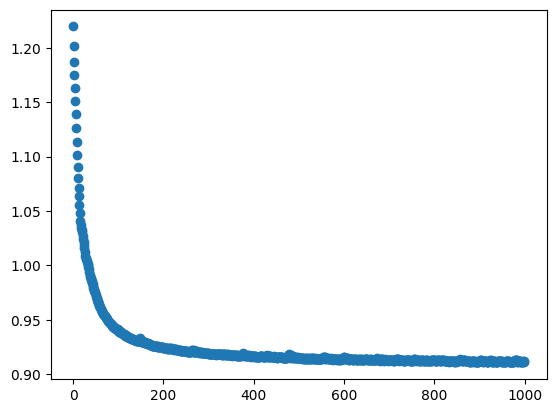

In [20]:
import torch
class Classifier(torch.nn.Module):
    def __init__(self, input_size, hidden_layers):
        super(Classifier, self).__init__()
        self.linear = torch.nn.Linear(input_size, input_size)
        # sequential
        layers = []
        for _ in range(hidden_layers):
            layers.append(torch.nn.Linear(input_size, input_size))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(0.1))
            
        self.sequential = torch.nn.Sequential(*layers)
        self.linear_end = torch.nn.Linear(input_size, 1)
        
    def forward(self, x):
        x = F.relu(self.linear(x))
        x = self.sequential(x)
        y_pred = F.sigmoid(self.linear_end(x))
        return y_pred

from sklearn.metrics import f1_score, precision_score, recall_score
def make_model(lr, hidden_layers):
    model = Classifier(train_X.shape[1], hidden_layers)
    X = torch.from_numpy(train_X).float()
    y = torch.from_numpy(train_y).float().unsqueeze(1)

    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.functional.binary_cross_entropy
    rescale_weight_botsamples = len(train_y[train_y==0])/len(train_y[train_y==1])

    model.train()
    model.cuda()
    X = X.cuda()
    y = y.cuda()
    
    for epoch in tqdm(range(1000)):
        y_pred = model(X)
        weights = torch.ones_like(y).cuda()
        weights[y==1] = rescale_weight_botsamples
        loss = criterion(y_pred, y, weight = weights)
        
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # validation set
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.from_numpy(val_X).float().cuda())
        f1 = f1_score(val_y, y_pred.detach().cpu()>0.5)
        precision = precision_score(val_y, y_pred.detach().cpu()>0.5)
        recall = recall_score(val_y, y_pred.detach().cpu()>0.5)
        print(f'val f1: {f1} precision: {precision} recall: {recall}')
    
    return f1, losses, model
        
# grid search
# if False:
lrs = [0.0001, 0.001, 0.01, 0.1,0.2]
hidden_layers = [0, 1,5,10]
lrs = [str(lr) for lr in lrs]
best_lr = None
best_hidden_layers = None
best_f1 = 0
best_model = None
best_losses = None
for hidden_layers in hidden_layers:
    for lr in lrs:
        print(f'lr: {lr}, hidden layers: {hidden_layers}')
        f1, losses, model = make_model(float(lr), hidden_layers)
        if f1 > best_f1:
            best_f1 = f1
            best_lr = lr
            best_model = model
            best_losses = losses
            best_hidden_layers = hidden_layers
# f1, losses, model = make_model(0.01)
print(f'best lr: {best_lr}, best hidden layers {best_hidden_layers}, val f1: {best_f1}')
plt.scatter(range(len(best_losses)), best_losses)
plt.show()


In [24]:
from sklearn.metrics import accuracy_score
# test performance on test set
model = best_model
model.eval()
with torch.no_grad():
    y_pred = model(torch.from_numpy(test_X).float().cuda())
    f1 = f1_score(test_y, y_pred.detach().cpu()>0.5)
    precision = precision_score(test_y, y_pred.detach().cpu()>0.5)
    recall = recall_score(test_y, y_pred.detach().cpu()>0.5)
    accuracy = accuracy_score(test_y, y_pred.detach().cpu()>0.5)
    print(f'test f1: {f1} accuracy: {accuracy} precision: {precision} recall: {recall} ')
    

test f1: 0.43258979661493363 accuracy: 0.7173928260717393 precision: 0.3008209538702111 recall: 0.7697749196141479 


The most optimal model from the above configurations is to be found simple logisitc regression utilizing the information about the relationship count per relationship type per user. During training, gradient information corresponding to the minority class (bot) is weighted proportionally higher.


Interestingly this model outperforms
(F1: 43.3±0 %)  many of the methods the original paper implements on the TwiBot-22 dataset for demonstration purposes [2] (The original paper unfortunately does not specify the exact methodology for training, including split ratios).
Although the model has only access to the F- (feature-) and G- (graph-) based information, no T- (text-) based information, it achieves acceptable F1 score in comparison, even outperforming the Heterogenous Graph Transformer (HGT) [4] in the F1 metric:
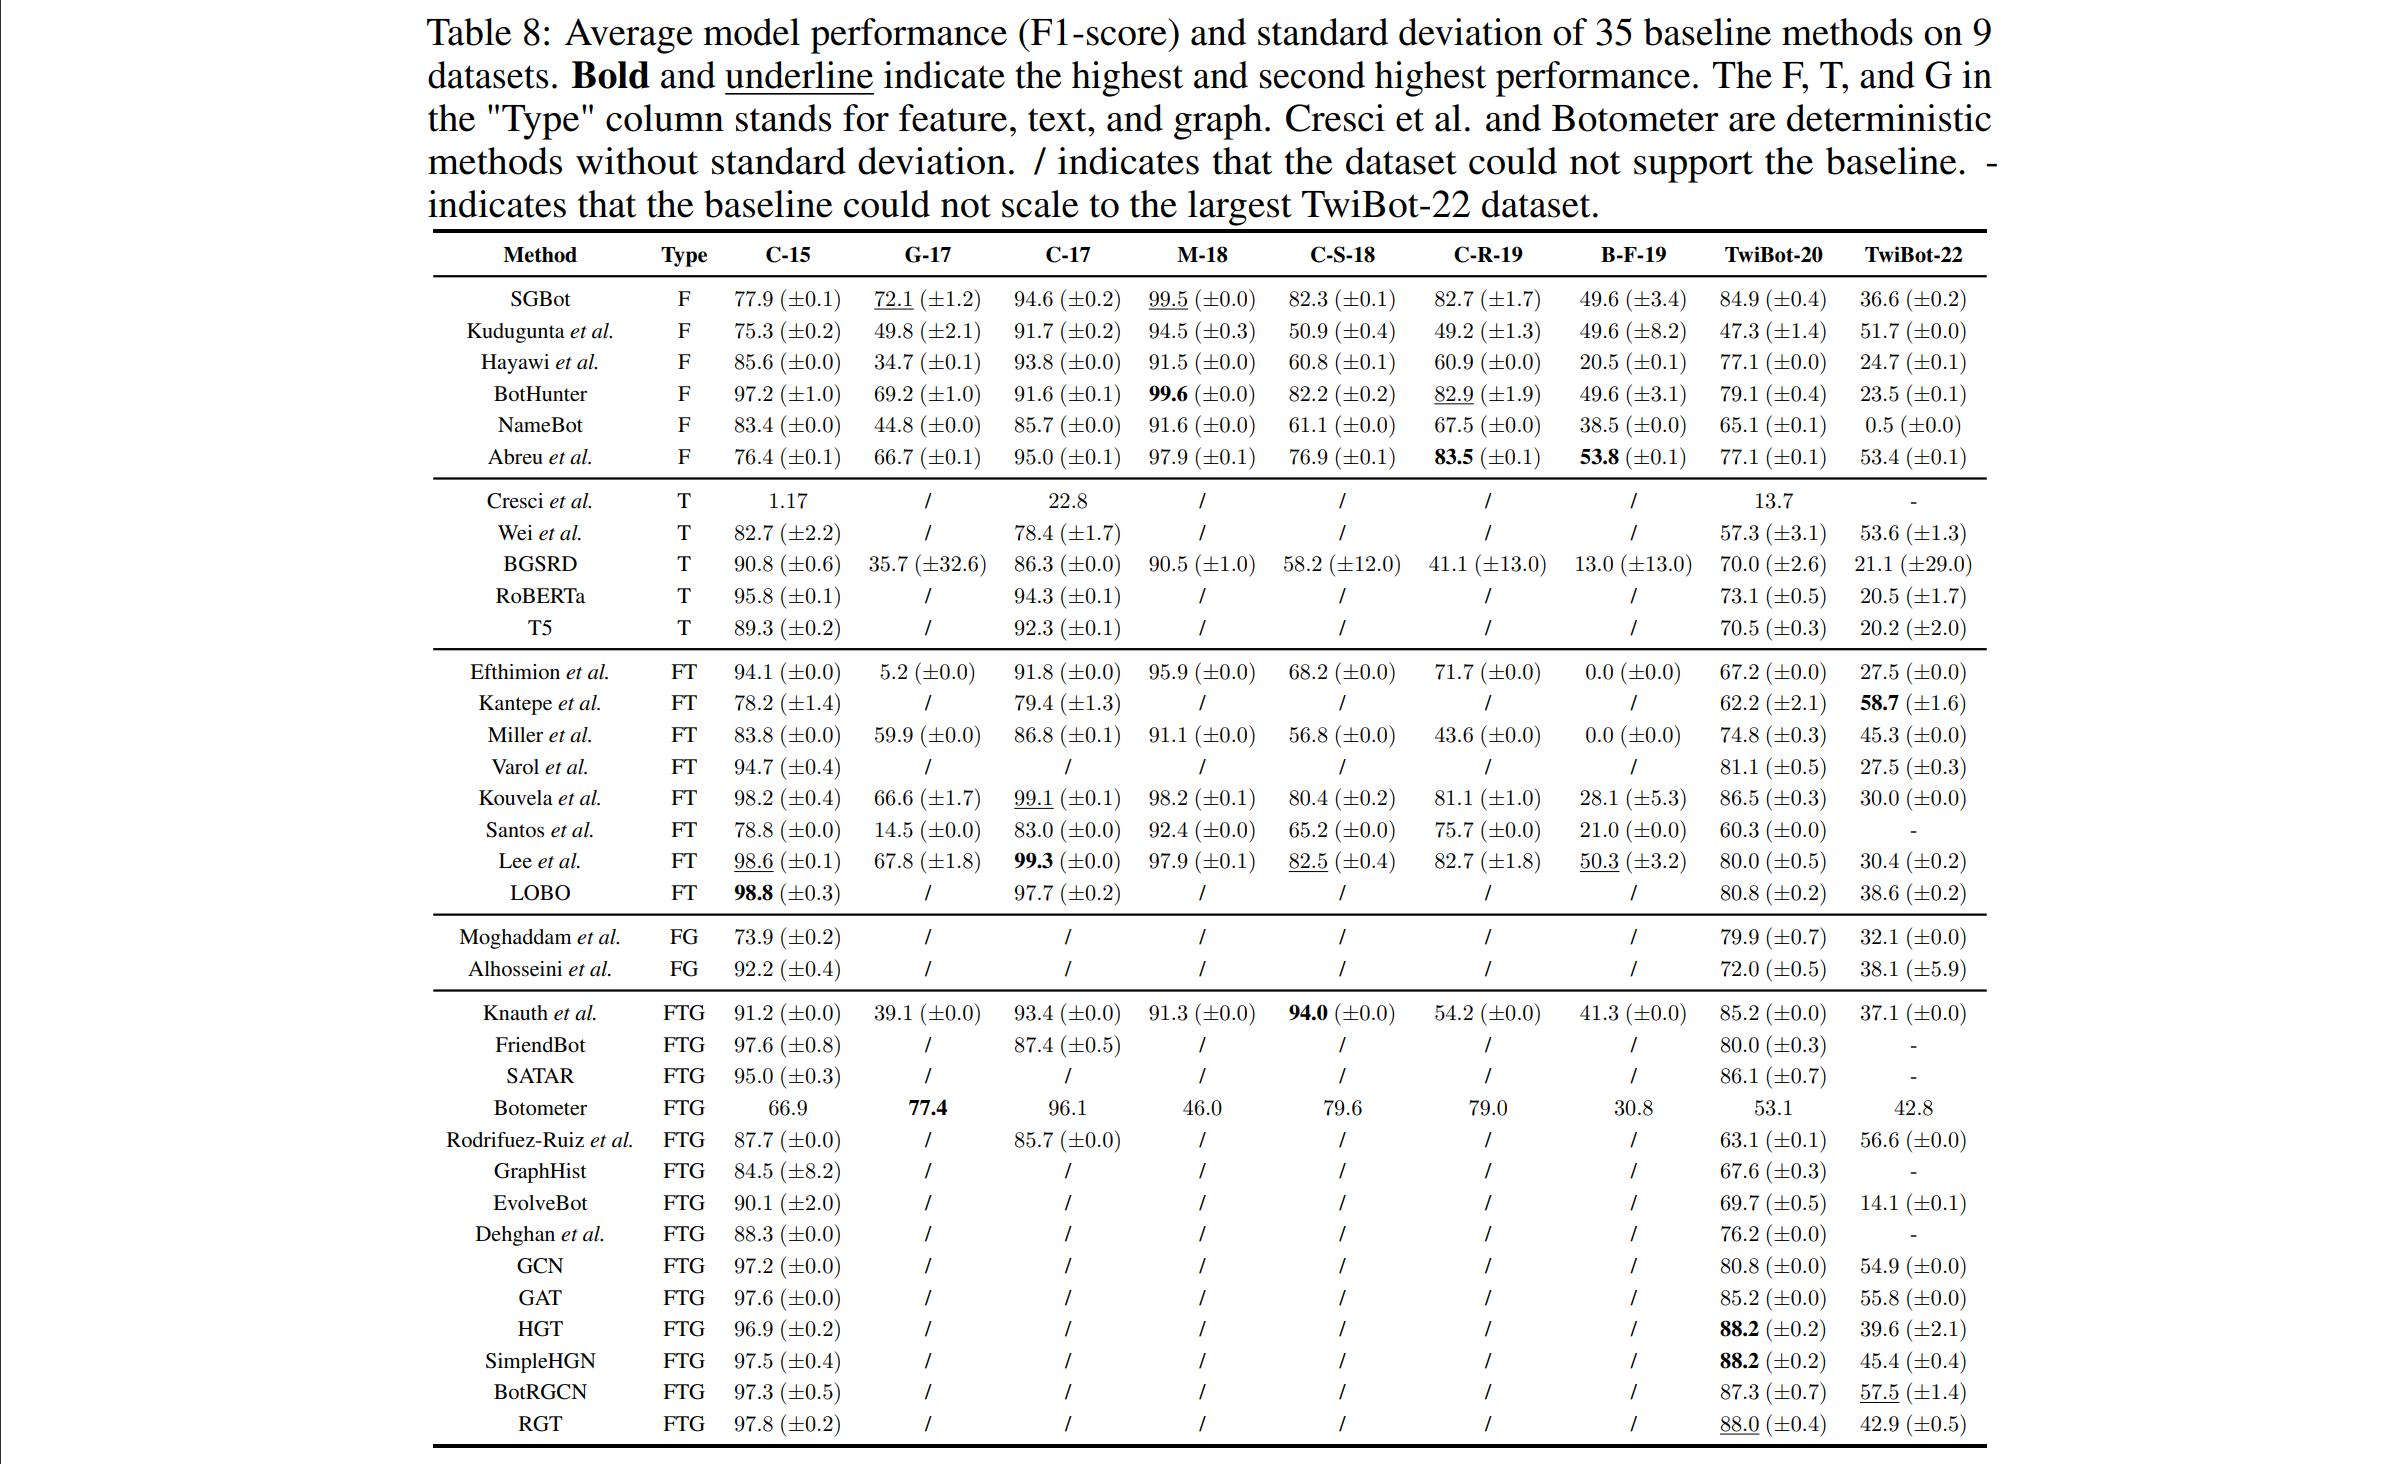

[4] https://arxiv.org/abs/2003.01332

The authors report accuracy scores as well although the highest performing model outperforms a majority-class predictor only by 1% (87% accuracy) [2].


In the following, the impact of the G-based information is explored further utilizing a Graph Neural Network.

In [31]:
all_relationship_counts = user_relationship_counts

In [32]:
all_relationship_counts

relation,source_id,contain,discuss,followed,followers,following,like,membership,mentioned,own,pinned,post,quoted,replied_to,retweeted
0,l10001332,99,0,5,0,0,0,7,0,0,0,0,0,0,0
1,l100016857,91,0,9,0,0,0,57,0,0,0,0,0,0,0
2,l100025292,97,0,1,0,0,0,1,0,0,0,0,0,0,0
3,l1000424073703313409,98,0,0,0,0,0,8,0,0,0,0,0,0,0
4,l1000427635304943616,100,0,0,0,0,0,14,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26963190,u999991981249097728,0,0,0,0,0,0,0,0,0,0,200,0,0,0
26963191,u999993859605172224,0,0,0,0,0,0,0,0,0,0,42,0,0,0
26963192,u999996175070711808,0,0,0,0,0,0,0,0,1,1,47,0,0,0
26963193,u999996786,0,0,0,0,0,0,0,0,0,0,40,0,0,0


In [ ]:
# Create graph dataset
from torch_geometric.data import HeteroData
data = HeteroData()
data['user'].num_nodes = len(user_id)
data[]

In [ ]:
# define graph dataset
import torch_geometric
from torch_geometric.data import HeteroData

In [ ]:
from torch_geometric.nn import HGTConv, Linear
import torch 

class HGT(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels, num_heads, num_layers, node_types, data_metadata):
        super().__init__()

        self.lin_dict = torch.nn.ModuleDict()
        for node_type in node_types:
            self.lin_dict[node_type] = Linear(-1, hidden_channels)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(hidden_channels, hidden_channels, data_metadata,
                           num_heads, group='sum')
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        x_dict = {
            node_type: self.lin_dict[node_type](x).relu_()
            for node_type, x in x_dict.items()
        }

        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)

        return x_dict
    
if __name__ == '__main__':
    model = HGT(hidden_channels=64, out_channels=4, num_heads=2, num_layers=1, node_types=data.node_types, data_metadata=data.metadata())

In [16]:
y.shape

NameError: name 'y' is not defined

In [ ]:
y_pred

tensor([[0.4004],
        [0.3609],
        [0.3914],
        ...,
        [0.3901],
        [0.3765],
        [0.3851]], grad_fn=<SigmoidBackward0>)

In [ ]:
# train simple logistic regression
model = LogisticRegression()
model.fit(train_X, train_y)

LogisticRegression()

In [ ]:
# get f1 score
def get_f1(y_hat, y):
    tp = ((y_hat==1) & (y==1)).sum()
    #tn = ((y_hat==0) & (y==0)).sum()
    fp = ((y_hat==1) & (y==0)).sum()
    fn = ((y_hat==0) & (y==1)).sum()
    
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn) 
    print(precision, recall)
    f1 = 2*precision*recall/(precision+recall)
    return f1

y_hat = model.predict(train_X)

# accuracy
print('Train f1:', get_f1(y_hat, train_y))

test_X1 = user_relationship_users_only_counts.loc[user_relationship_users_only_counts.source_id.isin(test_df.user_id.values)].drop('source_id', axis=1).values
test_X2 = user_data_df[user_data_df.user_id.isin(test_df.user_id.values)].drop('user_id', axis=1).values
test_X = np.concatenate([test_X1, test_X2], axis=1)
test_X = fitted_scaler.transform(test_X)
test_y = test_df.label.values
y_hat = model.predict(test_X)

print('Test f1:', get_f1(y_hat, test_y))


0.3575418994413408 0.0005648969504391191
Train f1: 0.00112801170312142
0.125 7.145409074669524e-05
Test f1: 0.0001428265371706063
